## Imports and Global Variables

In [1]:
import os
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from numpy import dot
from torch import optim
from collections import Counter
from numpy.linalg import norm
from tqdm.auto import tqdm
from torch.autograd import Variable
from torch.nn.functional import cross_entropy
from torch.utils.data import Dataset, DataLoader

In [2]:
EPOCHS = 50
MODE = "TEST"
LR = 1e-5
BATCH_SIZE = 32

In [3]:
CONV_FILTERS = list()
CONV_FILTERS.append([1, 32])
CONV_FILTERS.append([2, 32])
CONV_FILTERS.append([3, 64])
CONV_FILTERS.append([4, 128])
CONV_FILTERS.append([5, 256])
CONV_FILTERS.append([6, 512])
CONV_FILTERS.append([7, 1024])

In [4]:
NUM_HIGHWAY = 2
CHAR_EMBED_DIM = 50
WORD_EMBED_DIM = 300
MAX_CHAR = 50
MIN_COUNT = 5
MAX_LEN = 256
OUTPUT_DIM = 150
NUM_UNITS = 256
NUM_LAYERS = 2

In [5]:
if MODE == "TRAIN":
    with open("./data/corpus.json") as f:
        CORPUS = json.load(f)

In [6]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print("device - " + str(device))

device - cuda


In [7]:
!nvidia-smi

Tue Nov  9 16:41:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
| 29%   24C    P0    52W / 250W |     11MiB / 11019MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:82:00.0 Off |                  N/A |
| 31%   24C    P0    47W / 250W |     11MiB / 11019MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
        

## Classes and Functions

In [8]:
TOKENIZER = {}

In [9]:
def tokenize(text):
    w = torch.LongTensor(MAX_LEN).fill_(TOKENIZER["word2id"].get("<pad>"))
    c = torch.LongTensor(MAX_LEN, MAX_CHAR).fill_(TOKENIZER["char2id"].get("<pad>"))
    words = text.lower().split()
    for indx, word in enumerate(words[:MAX_LEN]):
        w[indx] = TOKENIZER["word2id"].get(word, TOKENIZER["word2id"].get("<oov>"))
        for indx2, char in enumerate(word[:MAX_CHAR]):
            c[indx][indx2] = TOKENIZER["char2id"].get(char, TOKENIZER["char2id"].get("<oov>"))
    return w, c, len(words[:MAX_LEN])

In [11]:
if MODE == "TRAIN":
    word_count = Counter()
    for sentence in CORPUS:
        word_count.update(sentence.lower().split())
    word_count = list(word_count.items())
    vocab = [w[0] for w in word_count if w[1] >= MIN_COUNT]
    TOKENIZER["word2id"] = {
        "<oov>" : 0,
        "<pad>": 1
    }
    TOKENIZER["char2id"] = {
        "<oov>" : 0,
        "<pad>": 1
    }
    for sentence in CORPUS:
        for word in sentence.split():
            word_lower = word.lower()
            if word_lower in vocab and word_lower not in TOKENIZER["word2id"]:
                TOKENIZER["word2id"][word_lower] = len(TOKENIZER["word2id"])
            for char in word:
                if char not in TOKENIZER["char2id"]:
                    TOKENIZER["char2id"][char] = len(TOKENIZER["char2id"])

In [12]:
if MODE == "TEST":
    with open(f"./checkpoints/tokenized.json") as f:
        d = json.load(f)
    TOKENIZER["word2id"] = d["word2id"]
    TOKENIZER["char2id"] = d["char2id"]

In [14]:
N_CONV_FILTERS = sum(z[1] for z in CONV_FILTERS)
FINAL_EMBED_DIM = WORD_EMBED_DIM + N_CONV_FILTERS
char2id_len = len(TOKENIZER["char2id"])
word2id_len = len(TOKENIZER["word2id"])
PADDING_INDX_CHAR = TOKENIZER["char2id"].get("<pad>")
PADDING_INDX_WORD = TOKENIZER["word2id"].get("<pad>")

In [15]:
class elmoDS(Dataset):
    def __getitem__(self, indx):
        text = CORPUS[indx]
        word, char, i = tokenize(text, max_length = MAX_LEN, max_char = MAX_CHAR)
        return char, word, i
    
    def __len__(self):
        return len(CORPUS)

In [16]:
if MODE == "TRAIN":
    data = elmoDS()
    data_loader = DataLoader(data, batch_size = BATCH_SIZE)

In [17]:
# Inspirations form https://gist.github.com/Redchards/65f1a6f758a1a5c5efb56f83933c3f6e
class Highway(nn.Module):
    def __init__(self, inp_dim, n_layers, activation):
        super(Highway, self).__init__()
        self.inp_dim = inp_dim
        self.layers = nn.ModuleList([nn.Linear(inp_dim, inp_dim * 2) for i in range(n_layers)])
        self.activation = activation
        for layer in self.layers:
            layer.bias[inp_dim:].data.fill_(1)
    
    def forward(self, inp):
        cur_inp = inp
        for l in self.layers:
            proj_inp = l(cur_inp)
            l_p = cur_inp
            nl_p = self.activation(proj_inp[:, 0 : self.inp_dim])
            g = torch.sigmoid(proj_inp[:, self.inp_dim : (2 * self.inp_dim)])
            cur_inp = g * l_p + (1 - g) * nl_p
        return cur_inp

In [18]:
class elmo(nn.Module):
    def __init__(self):
        super(elmo, self).__init__()
        self.char_e = nn.Embedding(char2id_len, CHAR_EMBED_DIM, padding_idx = PADDING_INDX_CHAR)
        self.word_e = nn.Embedding(word2id_len, WORD_EMBED_DIM, padding_idx = PADDING_INDX_WORD)
        self.activation = nn.ReLU()
        conv_list = []
        for w, h in CONV_FILTERS:
            conv_list.append(nn.Conv1d(in_channels = CHAR_EMBED_DIM, out_channels = h, kernel_size = w, bias = True))
        self.convs = nn.ModuleList(conv_list)
        self.highway = Highway(N_CONV_FILTERS, NUM_HIGHWAY, activation = self.activation)
        self.proj = nn.Linear(FINAL_EMBED_DIM, OUTPUT_DIM, bias = True)
        fLSTM = []
        bLSTM = []
        for x in range(NUM_LAYERS):
            if x == 0:
                fLSTM.append(nn.LSTM(input_size = OUTPUT_DIM, hidden_size = NUM_UNITS, batch_first = True))
                bLSTM.append(nn.LSTM(input_size = OUTPUT_DIM, hidden_size = NUM_UNITS, batch_first = True))
            else:
                fLSTM.append(nn.LSTM(input_size = NUM_UNITS, hidden_size = NUM_UNITS, batch_first = True))
                bLSTM.append(nn.LSTM(input_size = NUM_UNITS, hidden_size = NUM_UNITS, batch_first = True))
        self.fLSTM = nn.ModuleList(fLSTM)
        self.bLSTM = nn.ModuleList(bLSTM)
        self.linL = nn.Linear(in_features = NUM_UNITS, out_features = word2id_len)
    
    def forward(self, char_input, word_input):
        embeddings = []
        batch_size = word_input.size(0)
        seq_len = word_input.size(1)
        embeddings.append(self.word_e(Variable(word_input)))
        char_input = char_input.view(batch_size * seq_len, -1)
        char_em = self.char_e(Variable(char_input)).transpose(1, 2)
        conv_list = []
        for x in range(len(self.convs)):
            c, temp = torch.max(self.convs[x](char_em), dim = -1)
            conv_list.append(self.activation(c))
        char_em = self.highway(torch.cat(conv_list, dim = -1))
        embeddings.append(char_em.view(batch_size, -1, N_CONV_FILTERS))
        embeddings = self.proj(torch.cat(embeddings, dim = 2))
        forward = []
        backward = []
        forward.append(embeddings)
        backward.append(embeddings)
        for f_layer, b_layer in zip(self.fLSTM, self.bLSTM):
            forward.append(f_layer(forward[-1])[0])
            backward.append(torch.flip(b_layer(torch.flip(backward[-1], dims = [1, ]))[0], dims = [1, ]))
        return forward, backward

## Training

In [19]:
model = elmo()
model.to(device)

elmo(
  (char_e): Embedding(45, 50, padding_idx=1)
  (word_e): Embedding(10742, 300, padding_idx=1)
  (activation): ReLU()
  (convs): ModuleList(
    (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
    (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
    (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
    (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
    (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
    (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
    (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
  )
  (highway): Highway(
    (layers): ModuleList(
      (0): Linear(in_features=2048, out_features=4096, bias=True)
      (1): Linear(in_features=2048, out_features=4096, bias=True)
    )
    (activation): ReLU()
  )
  (proj): Linear(in_features=2348, out_features=150, bias=True)
  (fLSTM): ModuleList(
    (0): LSTM(150, 256, batch_first=True)
    (1): LSTM(256, 256, batch_first=True)
  )
  (bLSTM): ModuleList(
    (0): LSTM(150, 256, batch_first=True)
    (

In [20]:
opt = optim.Adam(model.parameters(), lr = LR)
loss_func = torch.nn.NLLLoss()

In [22]:
with open(f"./checkpoints/tokenized.json", "w") as f:
    json.dump({"word2id": TOKENIZER["word2id"], "char2id": TOKENIZER["char2id"]}, f, indent=4)

In [20]:
for epoch in range(EPOCHS):
    total_loss = 0
    print(f"Epoch - {epoch}")
    for batch in tqdm(data_loader):
        total_loss = 0
        chars, words, i = batch
        chars = chars.to(device)
        words = words.to(device)
        forward, backward = model(chars, words)
        forward = forward[-1]
        backward = backward[-1]
        max_k = torch.max(i)
        loss = 0
        for k in range(1, max_k):
            fp = forward[:, k-1, :]
            bp = backward[:, k-1, :]
            f_layer = model.linL(fp).squeeze()
            b_layer = model.linL(bp).squeeze()
            f_loss = torch.nn.functional.log_softmax(f_layer, dim = 1).squeeze()
            b_loss = torch.nn.functional.log_softmax(b_layer, dim = 1).squeeze()
            loss += loss_func(f_loss, words[:, k]) 
            loss += loss_func(b_loss, words[:, k])
        loss.backward()
        opt.step()
        opt.zero_grad()
        model.zero_grad()
        total_loss += loss.detach().item()
    
    if epoch%2 == 1 or epoch == EPOCHS - 1:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': total_loss,
        }, f"./checkpoints/model.pt")
    print(f"Total Loss - {total_loss}")

Epoch - 0


  0%|          | 0/1 [00:00<?, ?it/s]

Total Loss - 105.56830596923828


## Testing

In [18]:
model = elmo()
model.load_state_dict(torch.load(f"./checkpoints/model.pt"), strict=False)
model.to(device)

elmo(
  (char_e): Embedding(45, 50, padding_idx=1)
  (word_e): Embedding(10742, 300, padding_idx=1)
  (activation): ReLU()
  (convs): ModuleList(
    (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
    (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
    (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
    (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
    (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
    (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
    (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
  )
  (highway): Highway(
    (layers): ModuleList(
      (0): Linear(in_features=2048, out_features=4096, bias=True)
      (1): Linear(in_features=2048, out_features=4096, bias=True)
    )
    (activation): ReLU()
  )
  (proj): Linear(in_features=2348, out_features=150, bias=True)
  (fLSTM): ModuleList(
    (0): LSTM(150, 256, batch_first=True)
    (1): LSTM(256, 256, batch_first=True)
  )
  (bLSTM): ModuleList(
    (0): LSTM(150, 256, batch_first=True)
    (

In [19]:
def euc_dist(v1, v2):
    return np.linalg.norm(v1 - v2)

In [20]:
def cos_sim(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1) * norm(v2))

In [21]:
def sim(e, w_to_i, w1, w2):
    return cos_sim(e[w_to_i[w1]], e[w_to_i[w2]]), euc_dist(e[w_to_i[w1]], e[w_to_i[w2]])

In [22]:
def gen_embeddings(sentence, word):
    indx = sentence.split().index(word)
    model.eval()
    with torch.no_grad():
        words, chars, i = tokenize(sentence)
        chars = chars.unsqueeze(0).to(device)
        words = words.unsqueeze(0).to(device)
        forward, backward = model(chars, words)
        en_embedding = forward[0][0][indx].cpu().detach().numpy()
        h = list()
        for x in range(1, len(forward)):
            h.append(torch.cat((forward[x][0][indx], backward[x][0][indx])).cpu().detach().numpy())
    return np.mean(h, axis = 0) # Can be modified as required

In [23]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [24]:
test_corpus = []
test_words = []
e = []

In [25]:
test_corpus.append("I love the city atmosphere")
test_words.append("city")
test_corpus.append("This country has the largest lake")
test_words.append("country")

test_corpus.append("This phone is brand new")
test_words.append("phone")
test_corpus.append("His laptop has the best GPU")
test_words.append("laptop")

test_corpus.append("He is a good person")
test_words.append("good")
test_corpus.append("I love the bad boys movie")
test_words.append("bad")

test_corpus.append("India is one of the most diverse countries")
test_words.append("India")
test_corpus.append("Switzerland is a cold country")
test_words.append("Switzerland")

test_corpus.append("I use Manjaro, a linux distribution")
test_words.append("linux")
test_corpus.append("Microsoft's windows 10 OS is pretty good")
test_words.append("windows")

In [26]:
w_to_i = {w: indx for indx, w in enumerate(test_words)}

In [27]:
for indx, sentence in enumerate(test_corpus):
    e.append(gen_embeddings(sentence, test_words[indx]))

In [28]:
sim(e, w_to_i, "city", "country")

(0.7282851, 0.45772827)

In [29]:
sim(e, w_to_i, "phone", "laptop")

(0.62575483, 0.5027177)

In [30]:
sim(e, w_to_i, "good", "bad")

(0.69977117, 0.44556513)

In [31]:
sim(e, w_to_i, "India", "Switzerland")

(0.7204063, 0.41066405)

In [32]:
sim(e, w_to_i, "linux", "windows")

(0.79510134, 0.41506428)

In [33]:
col1 = []
col2 = []
col3 = []
col4 = []

In [34]:
for indx1, i in enumerate(test_words):
    for indx2, j in enumerate(test_words):
        col1.append(i)
        col2.append(j)
        s1, s2 = sim(e, w_to_i, i, j)
        col3.append(s1)
        col4.append(s2)

In [35]:
df = pd.DataFrame({"w1" : col1, "w2" : col2, "cos_sim": col3, "euc" : col4})

In [36]:
df

,w1,w2,cos_sim,euc
0,city,city,1.000000,0.000000
1,city,country,0.728285,0.457728
2,city,phone,0.670354,0.474456
3,city,laptop,0.681371,0.473020
4,city,good,0.764895,0.400133
...,...,...,...,...
95,windows,bad,0.692221,0.488637
96,windows,India,0.641737,0.510850
97,windows,Switzerland,0.727016,0.458991
98,windows,linux,0.795101,0.415064


In [37]:
plt.rcParams["figure.figsize"] = (20, 15)
plt.rcParams.update({'font.size': 12})

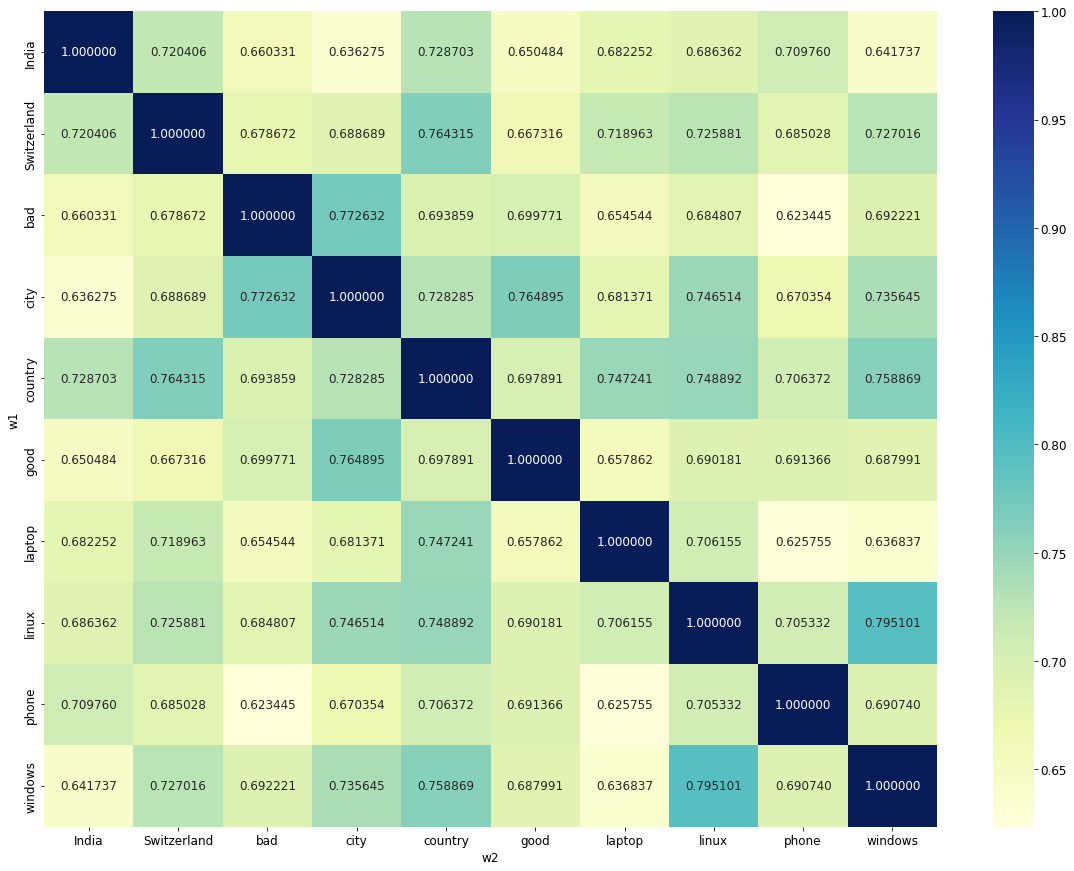

In [38]:
ax = sns.heatmap(df.pivot("w1", "w2", "cos_sim"), cmap="YlGnBu", annot=True, fmt="f")
plt.savefig("./figs/cos_sim.png")
plt.show()

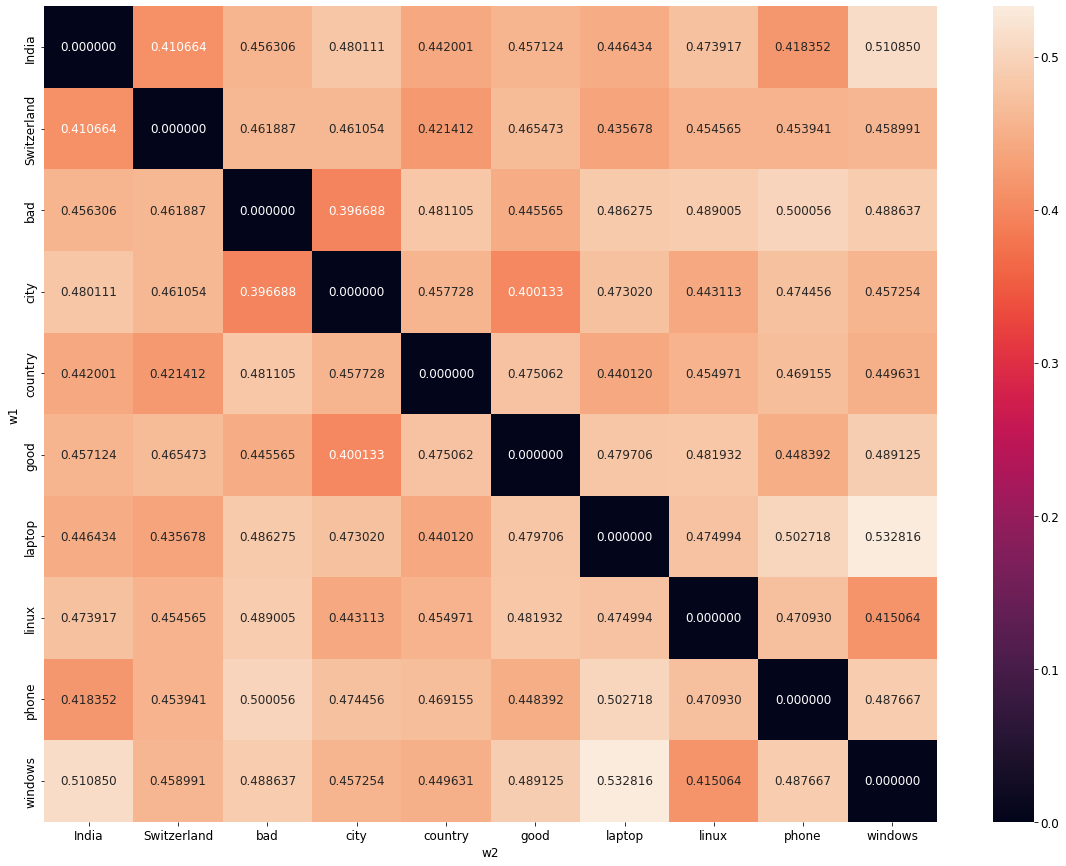

In [39]:
ax = sns.heatmap(df.pivot("w1", "w2", "euc"), annot=True, fmt="f")
plt.savefig("./figs/euc_dist.png")
plt.show()

In [40]:
w1 = gen_embeddings("Please bear with me throughout this talk", "bear")
w2 = gen_embeddings("Grizzly bear is dangerous", "bear")
disc = gen_embeddings("This zoo has animals from all over the world", "animals")

In [41]:
cos_sim(w1, disc)

0.6762283

In [42]:
cos_sim(w2, disc)

0.67782974